### Computer Use with Qwen3-VL

This notebook demonstrates how to use Qwen3-VL for computer use. It takes a screenshot of a user's desktop and a query, and then uses the model to interpret the user's query on the screenshot.

#### \[Setup\]

Load visualization utils.

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install qwen-agent
!pip install openai

In [ ]:
from PIL import Image, ImageDraw, ImageColor


def draw_point(image: Image.Image, point: list, color=None):
    if isinstance(color, str):
        try:
            color = ImageColor.getrgb(color)
            color = color + (128,)
        except ValueError:
            color = (255, 0, 0, 128)
    else:
        color = (255, 0, 0, 128)

    overlay = Image.new("RGBA", image.size, (255, 255, 255, 0))
    overlay_draw = ImageDraw.Draw(overlay)
    radius = min(image.size) * 0.05
    x, y = point

    overlay_draw.ellipse(
        [(x - radius, y - radius), (x + radius, y + radius)], fill=color
    )

    center_radius = radius * 0.1
    overlay_draw.ellipse(
        [
            (x - center_radius, y - center_radius),
            (x + center_radius, y + center_radius),
        ],
        fill=(0, 255, 0, 255),
    )

    image = image.convert("RGBA")
    combined = Image.alpha_composite(image, overlay)

    return combined.convert("RGB")

#### Computer Use with Inference API



In [ ]:
## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
import os

os.environ["DASHSCOPE_API_KEY"] = "your_api_key"

In [ ]:
import os
import json
import base64
from openai import OpenAI
from PIL import Image
from IPython.display import display
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from transformers.models.qwen2_vl.image_processing_qwen2_vl_fast import smart_resize

from utils.agent_function_call import ComputerUse


def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def perform_gui_grounding_with_api(
    screenshot_path, user_query, model_id, min_pixels=3136, max_pixels=12845056
):
    """
    Perform GUI grounding using Qwen model to interpret user query on a screenshot.

    Args:
        screenshot_path (str): Path to the screenshot image
        user_query (str): User's query/instruction
        model: Preloaded Qwen model
        min_pixels: Minimum pixels for the image
        max_pixels: Maximum pixels for the image

    Returns:
        tuple: (output_text, display_image) - Model's output text and annotated image
    """

    # Open and process image
    input_image = Image.open(screenshot_path)
    base64_image = encode_image(screenshot_path)
    client = OpenAI(
        # If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx". Access via https://bailian.console.alibabacloud.com/?apiKey=1 "
        api_key=os.getenv("DASHSCOPE_API_KEY"),
        base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )
    resized_height, resized_width = smart_resize(
        input_image.height,
        input_image.width,
        factor=32,
        min_pixels=min_pixels,
        max_pixels=max_pixels,
    )

    # Initialize computer use function
    computer_use = ComputerUse(
        cfg={"display_width_px": 1000, "display_height_px": 1000}
    )

    # Build messages
    system_message = NousFnCallPrompt().preprocess_fncall_messages(
        messages=[
            Message(
                role="system",
                content=[ContentItem(text="You are a helpful assistant.")],
            ),
        ],
        functions=[computer_use.function],
        lang=None,
    )
    system_message = system_message[0].model_dump()
    messages = [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": msg["text"]}
                for msg in system_message["content"]
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    # "min_pixels": 1024,
                    # "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": user_query},
            ],
        },
    ]
    print(json.dumps(messages, indent=4))
    completion = client.chat.completions.create(
        model=model_id,
        messages=messages,
    )

    output_text = completion.choices[0].message.content

    # Parse action and visualize
    action = json.loads(
        output_text.split("<tool_call>\n")[1].split("\n</tool_call>")[0]
    )
    coordinate_relative = action["arguments"]["coordinate"]
    coordinate_absolute = [
        coordinate_relative[0] / 1000 * resized_width,
        coordinate_relative[1] / 1000 * resized_height,
    ]

    display_image = input_image.resize((resized_width, resized_height))
    display_image = draw_point(display_image, coordinate_absolute, color="green")

    return output_text, display_image

[
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": "You are a helpful assistant."
            },
            {
                "type": "text",
                "text": "\n\n# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>\n{\"type\": \"function\", \"function\": {\"name\": \"computer_use\", \"description\": \"Use a mouse and keyboard to interact with a computer, and take screenshots.\\n* This is an interface to a desktop GUI. You do not have access to a terminal or applications menu. You must click on desktop icons to start applications.\\n* Some applications may take time to start or process actions, so you may need to wait and take successive screenshots to see the results of your actions. E.g. if you click on Firefox and a window doesn't open, try wait and taking another screenshot.\\n* The screen's
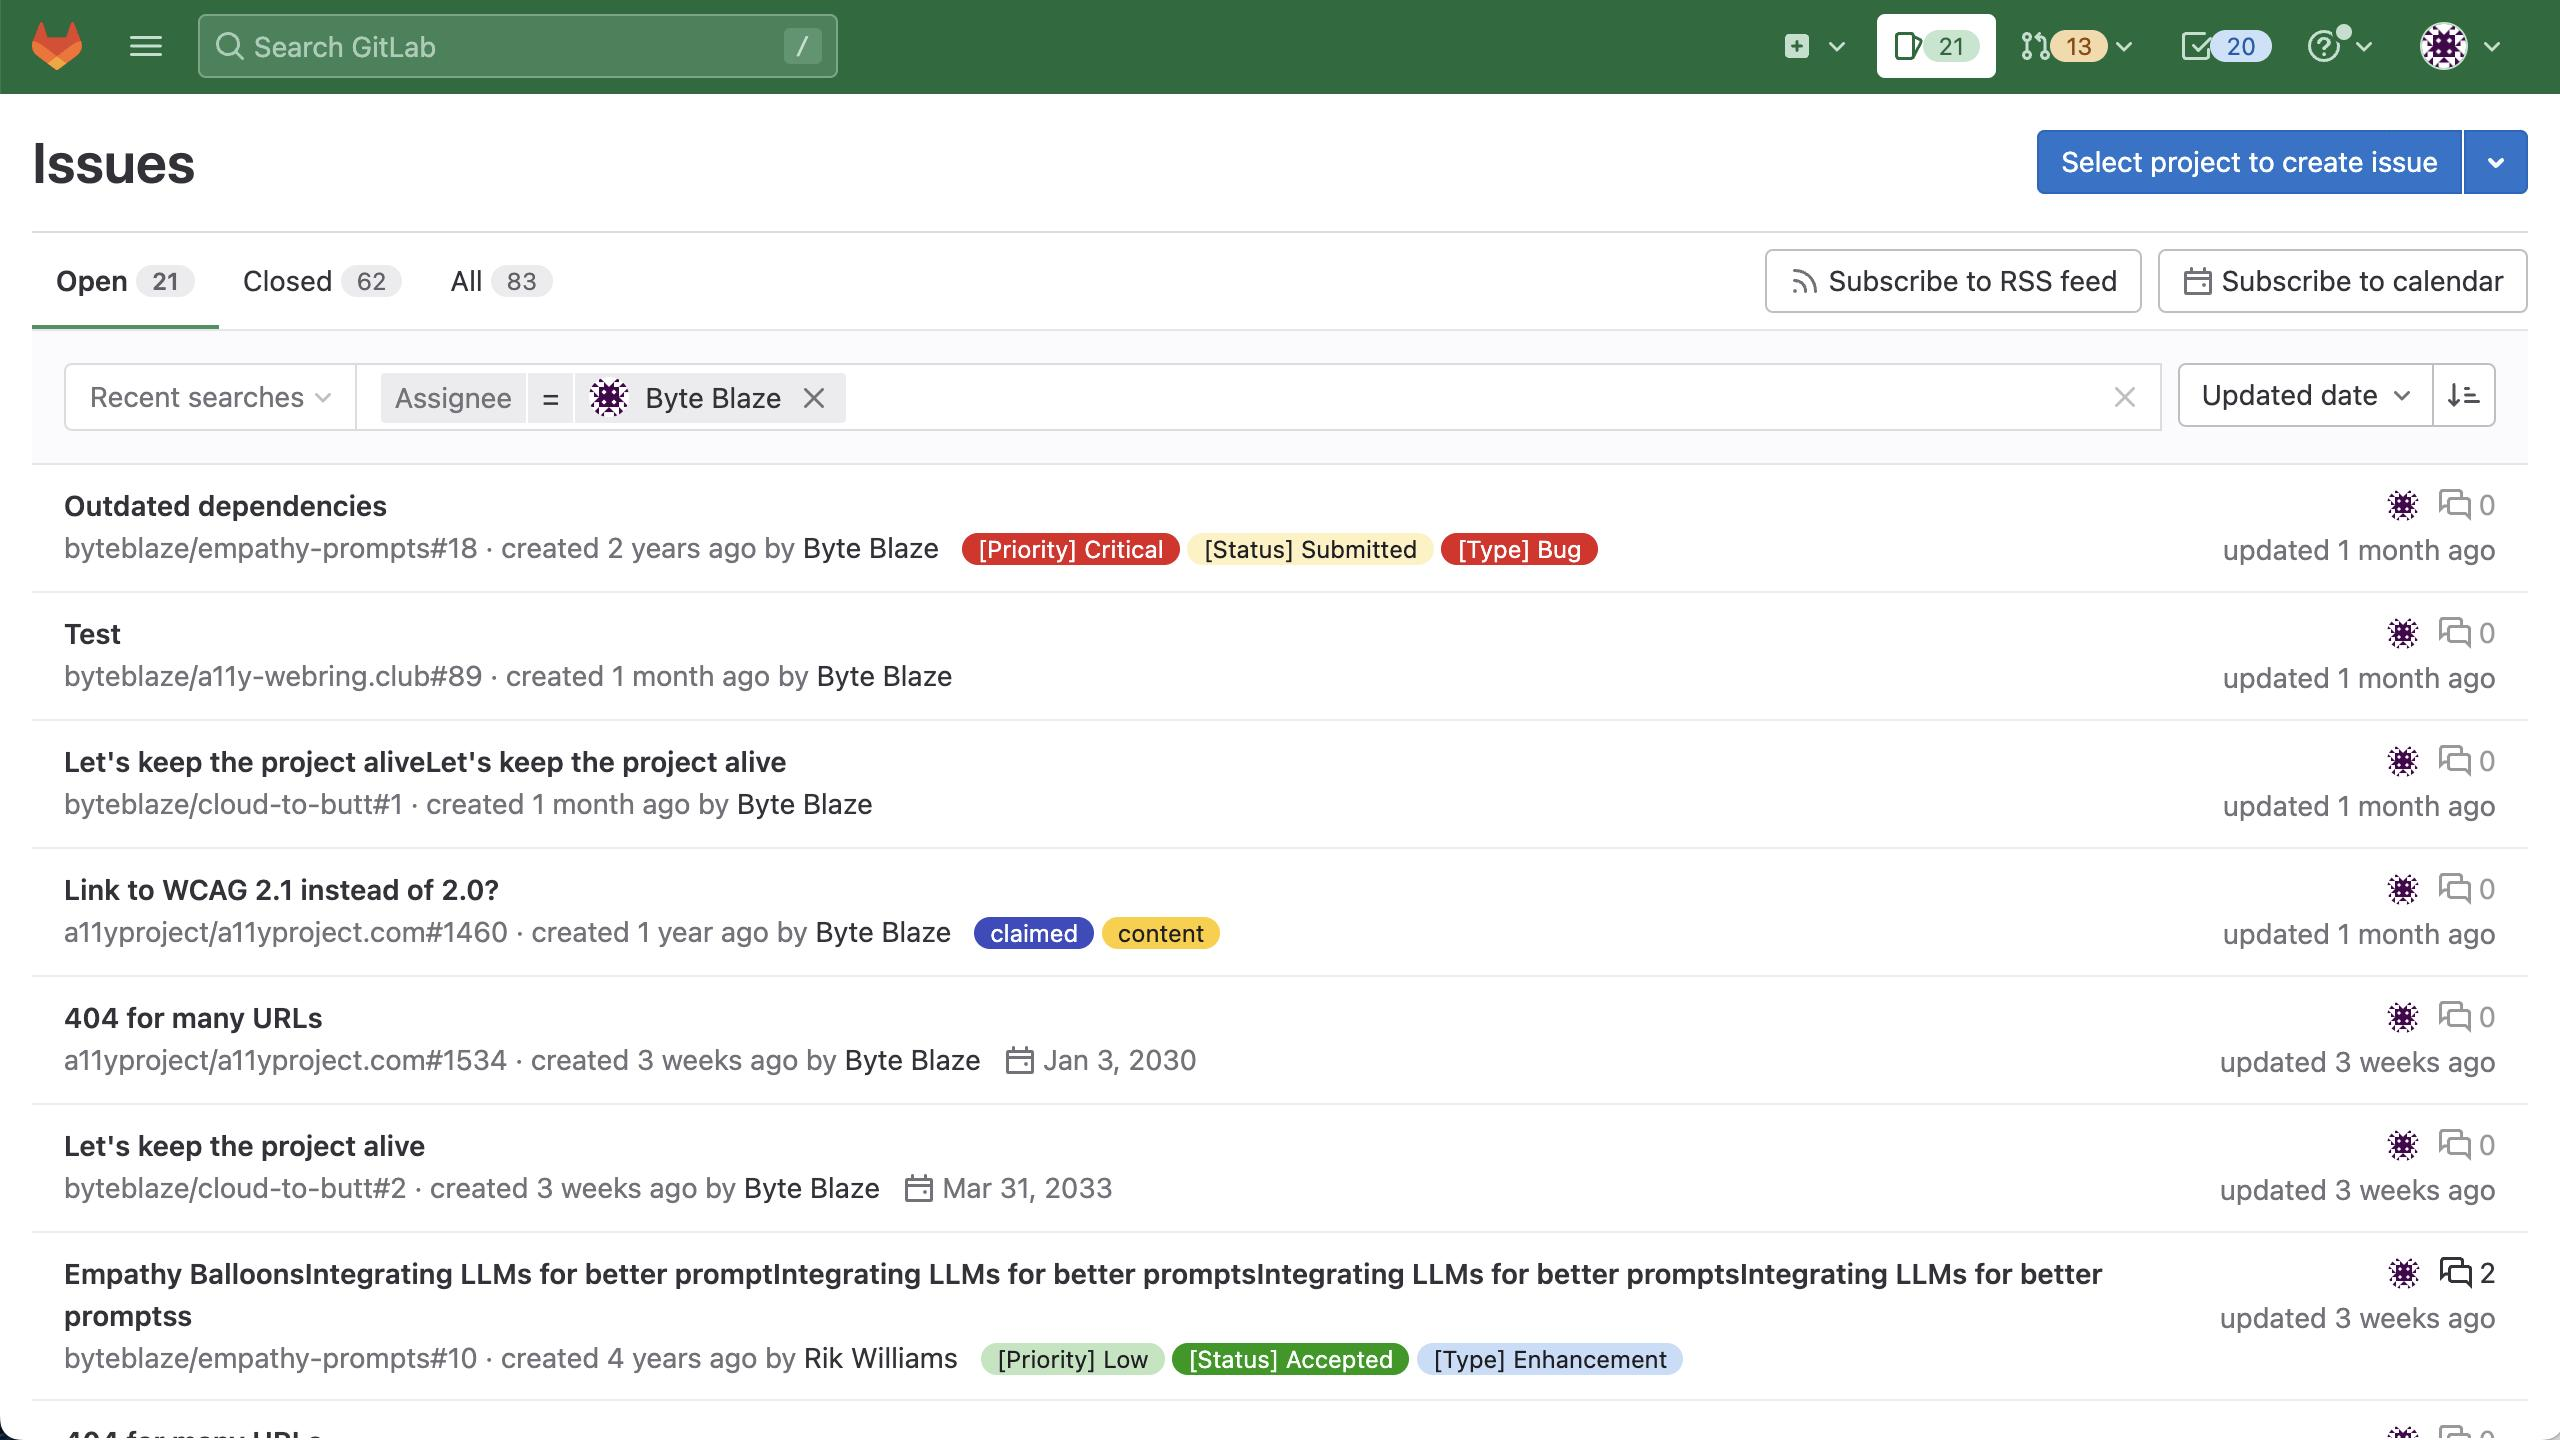

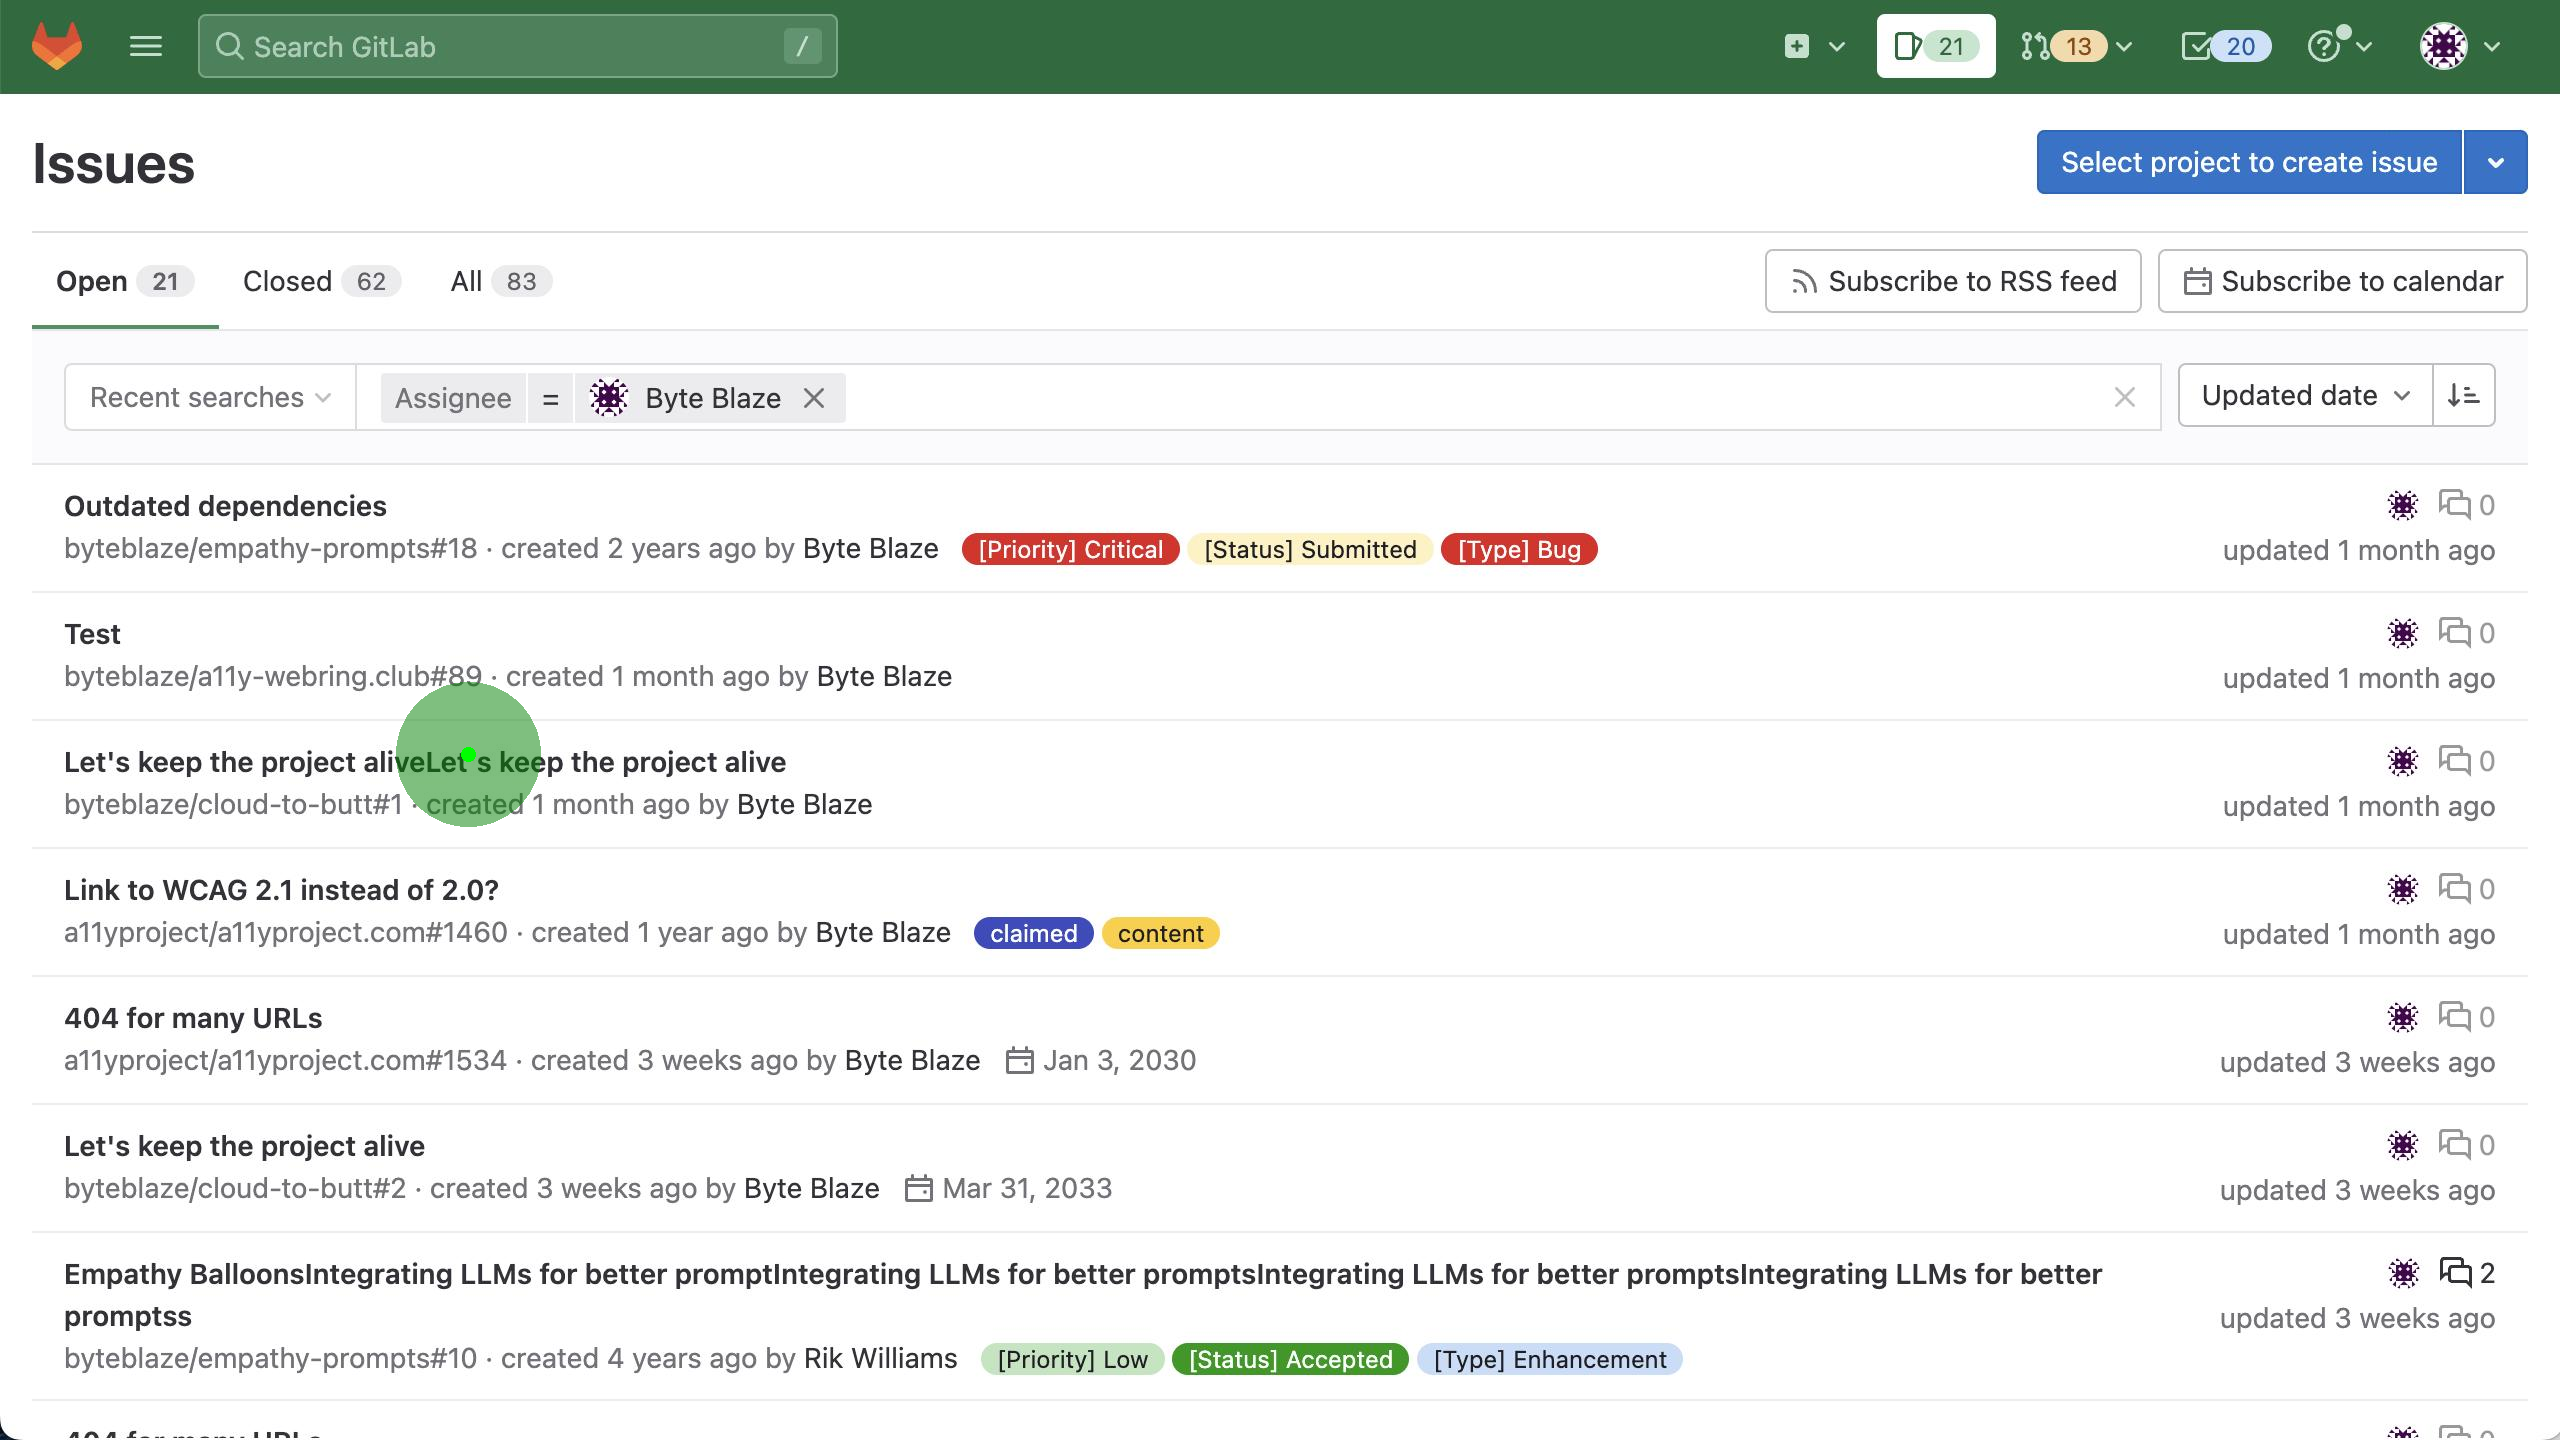

In [ ]:
# Example usage
screenshot = "assets/computer_use/computer_use2.jpeg"
user_query = "open the third issue"
model_id = "your model"
output_text, display_image = perform_gui_grounding_with_api(
    screenshot, user_query, model_id
)

# Display results
print(output_text)
display(display_image)

#### Computer Use with Local Model



In [ ]:
!pip install torch
!pip install flash-attn --no-build-isolation
!pip install accelerate

In [ ]:
from transformers import AutoProcessor, AutoModelForVision2Seq

model_path = "Qwen/Qwen3-VL-30B-A3B-Instruct"
processor = AutoProcessor.from_pretrained(model_path)
model, output_loading_info = AutoModelForVision2Seq.from_pretrained(
    model_path, torch_dtype="auto", device_map="auto", output_loading_info=True
)
print("output_loading_info", output_loading_info)

/mnt/jianke_z/miniconda3/envs/qwen3vl/lib/python3.11/site-packages/transformers/models/auto/modeling_auto.py:2287: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]

output_loading_info {'missing_keys': [], 'unexpected_keys': [], 'mismatched_keys': [], 'error_msgs': []}


In [ ]:
from PIL import Image
from IPython.display import display



def perform_gui_grounding(screenshot_path, user_query, model, processor):
    """
    Perform GUI grounding using Qwen model to interpret user query on a screenshot.

    Args:
        screenshot_path (str): Path to the screenshot image
        user_query (str): User's query/instruction
        model: Preloaded Qwen model
        processor: Preloaded Qwen processor

    Returns:
        tuple: (output_text, display_image) - Model's output text and annotated image
    """

    # Open and process image
    input_image = Image.open(screenshot_path)

    patch_size = processor.image_processor.patch_size
    merge_size = processor.image_processor.merge_size
    resized_height, resized_width = smart_resize(
        input_image.height,
        input_image.width,
        factor=patch_size * merge_size,
        min_pixels=patch_size * patch_size * merge_size * merge_size * 16,
        max_pixels=patch_size * patch_size * merge_size * merge_size * 6400,
    )

    # Initialize computer use function
    computer_use = ComputerUse(
        cfg={"display_width_px": 1000, "display_height_px": 1000}
    )

    # Build messages
    message = NousFnCallPrompt().preprocess_fncall_messages(
        messages=[
            Message(
                role="system",
                content=[ContentItem(text="You are a helpful assistant.")],
            ),
            Message(
                role="user",
                content=[
                    ContentItem(text=user_query),
                    ContentItem(image=f"file://{screenshot_path}"),
                ],
            ),
        ],
        functions=[computer_use.function],
        lang=None,
    )
    message = [msg.model_dump() for msg in message]

    # Process input
    text = processor.apply_chat_template(
        message, tokenize=False, add_generation_prompt=True
    )
    inputs = processor(
        text=[text], images=[input_image], padding=True, return_tensors="pt"
    ).to("cuda")

    # Generate output
    output_ids = model.generate(**inputs, max_new_tokens=2048)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )[0]

    # Parse action and visualize
    action = json.loads(
        output_text.split("<tool_call>\n")[1].split("\n</tool_call>")[0]
    )
    display_image = input_image.resize((resized_width, resized_height))
    display_x = action["arguments"]["coordinate"][0] / 1000 * resized_width
    display_y = action["arguments"]["coordinate"][1] / 1000 * resized_height
    display_image = draw_point(display_image, (display_x, display_y), color="green")

    return output_text, display_image

<tool_call>
{"name": "computer_use", "arguments": {"action": "left_click", "coordinate": [537, 336]}}
</tool_call>


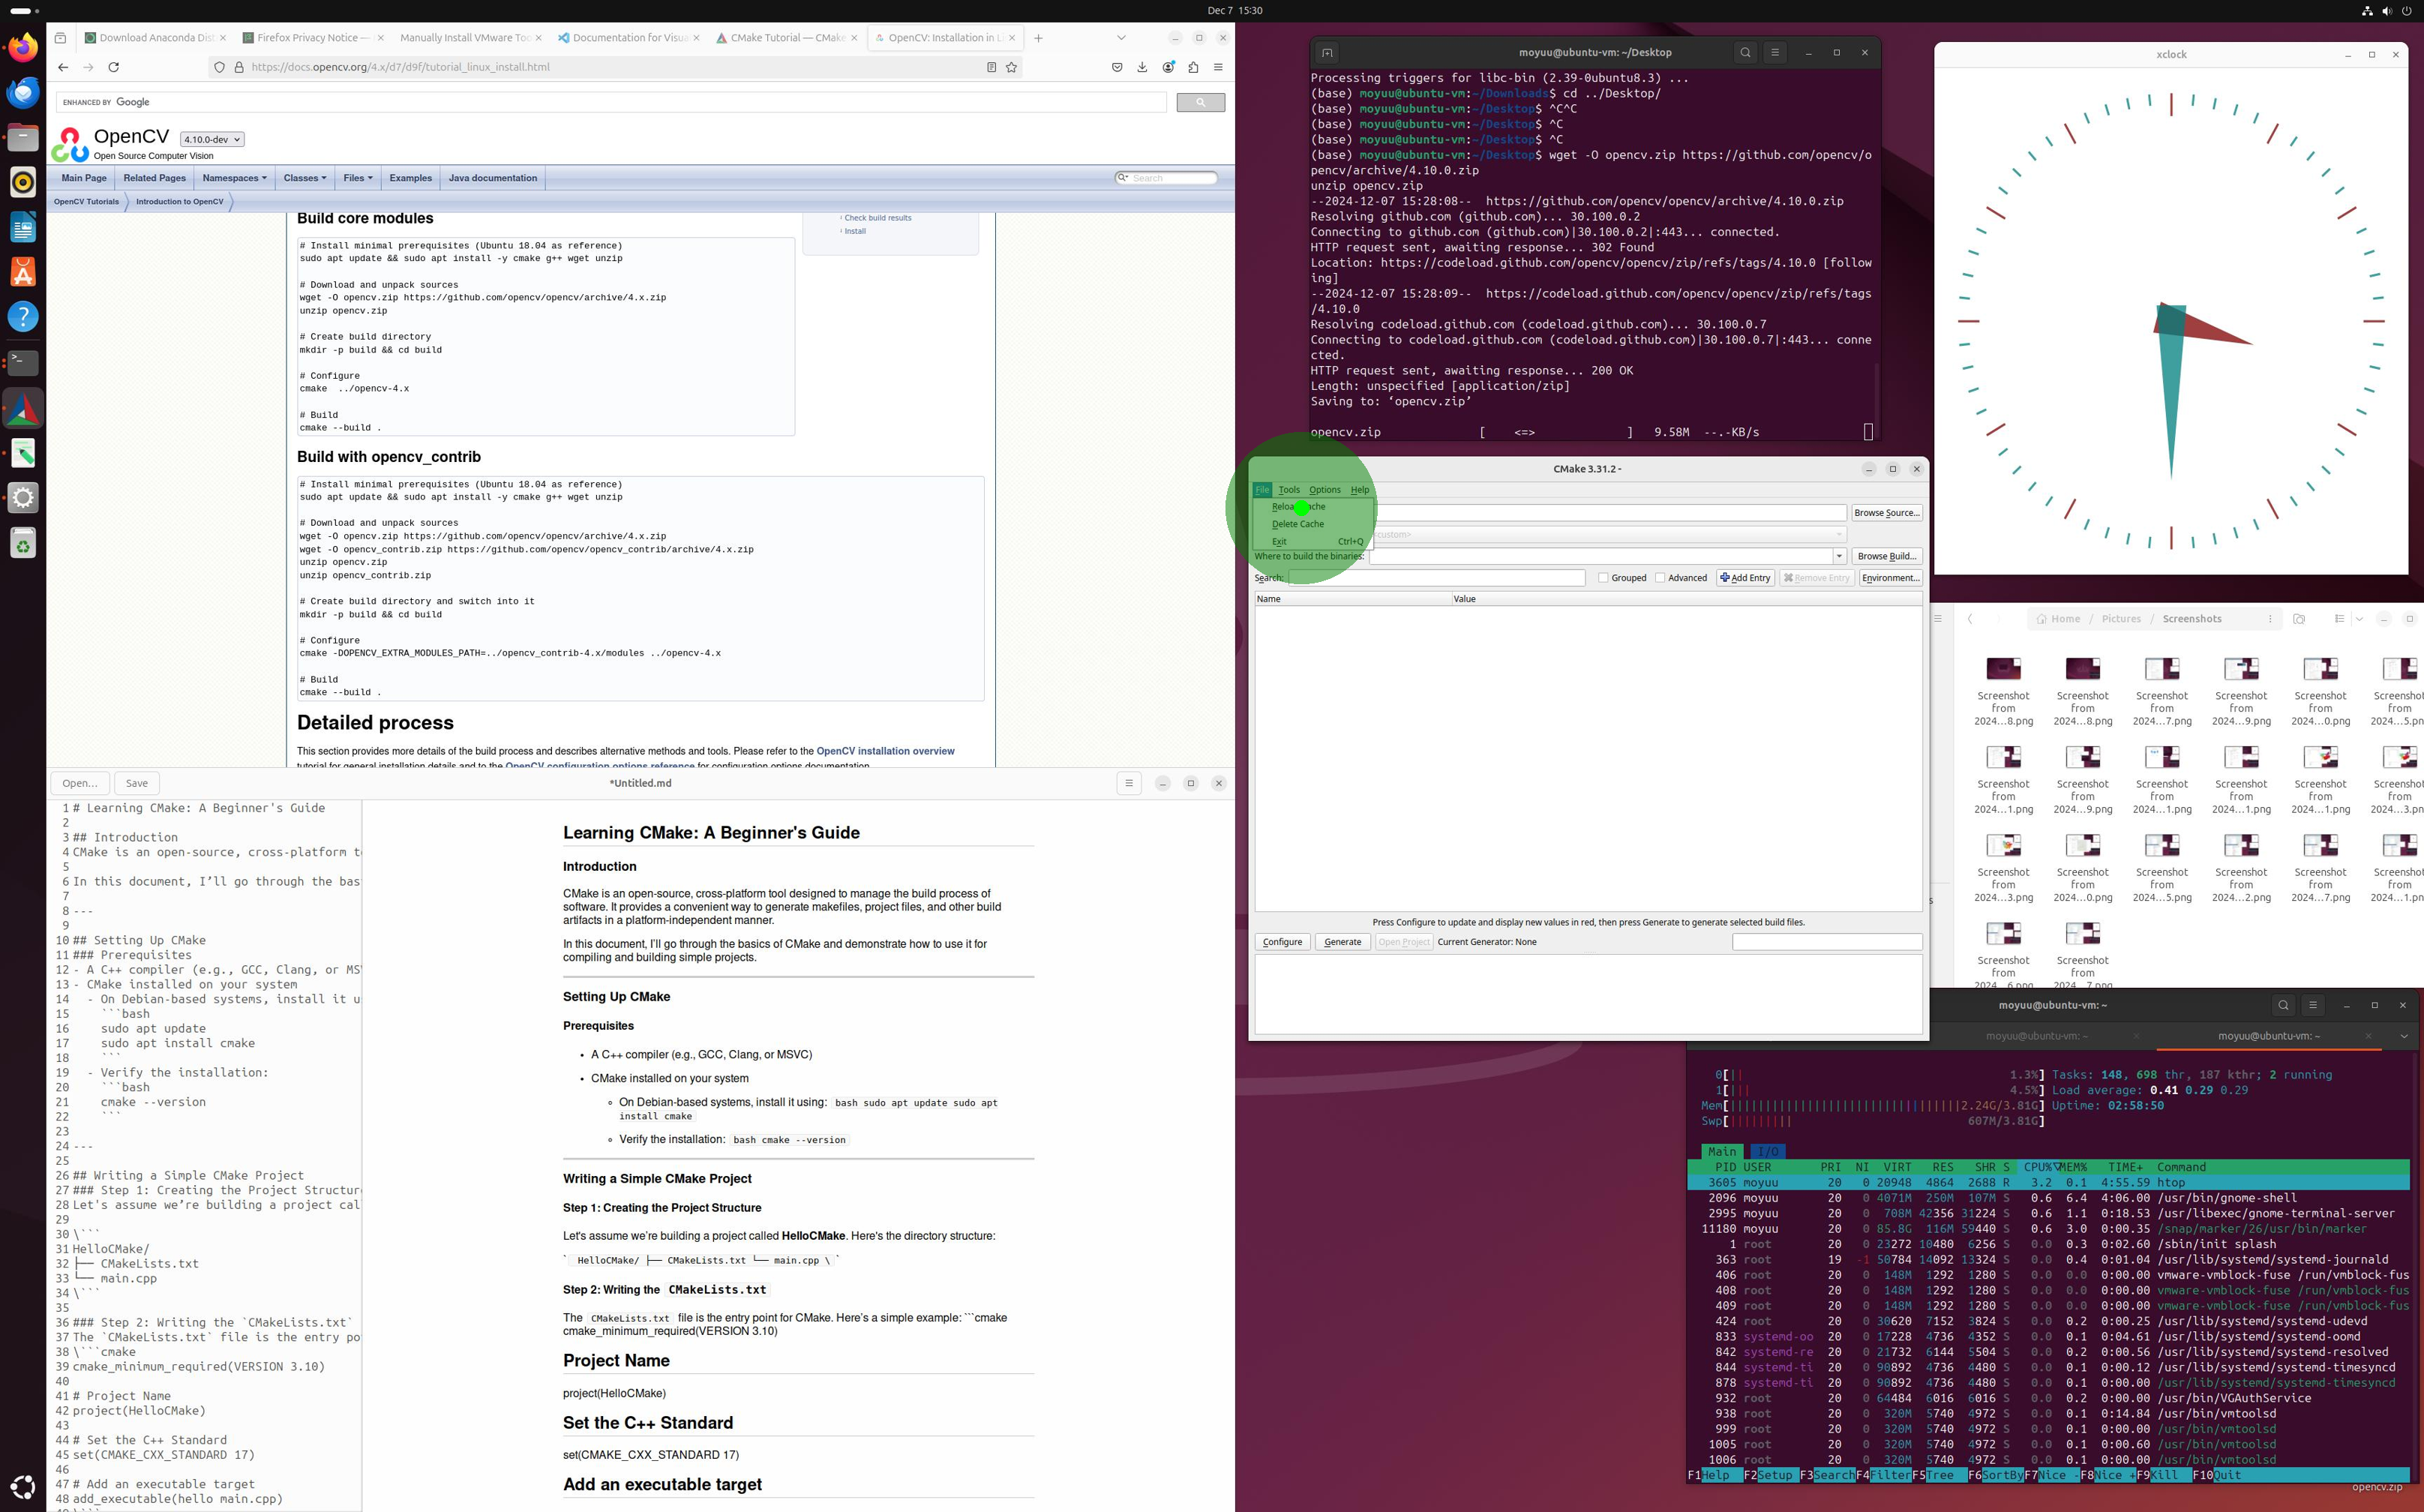

In [45]:
# Example usage
screenshot = "assets/computer_use/computer_use1.jpeg"
user_query = "Reload cache"
output_text, display_image = perform_gui_grounding(
    screenshot, user_query, model, processor
)

# Display results
print(output_text)
display(display_image)

<tool_call>
{"name": "computer_use", "arguments": {"action": "left_click", "coordinate": [108, 350]}}
</tool_call>


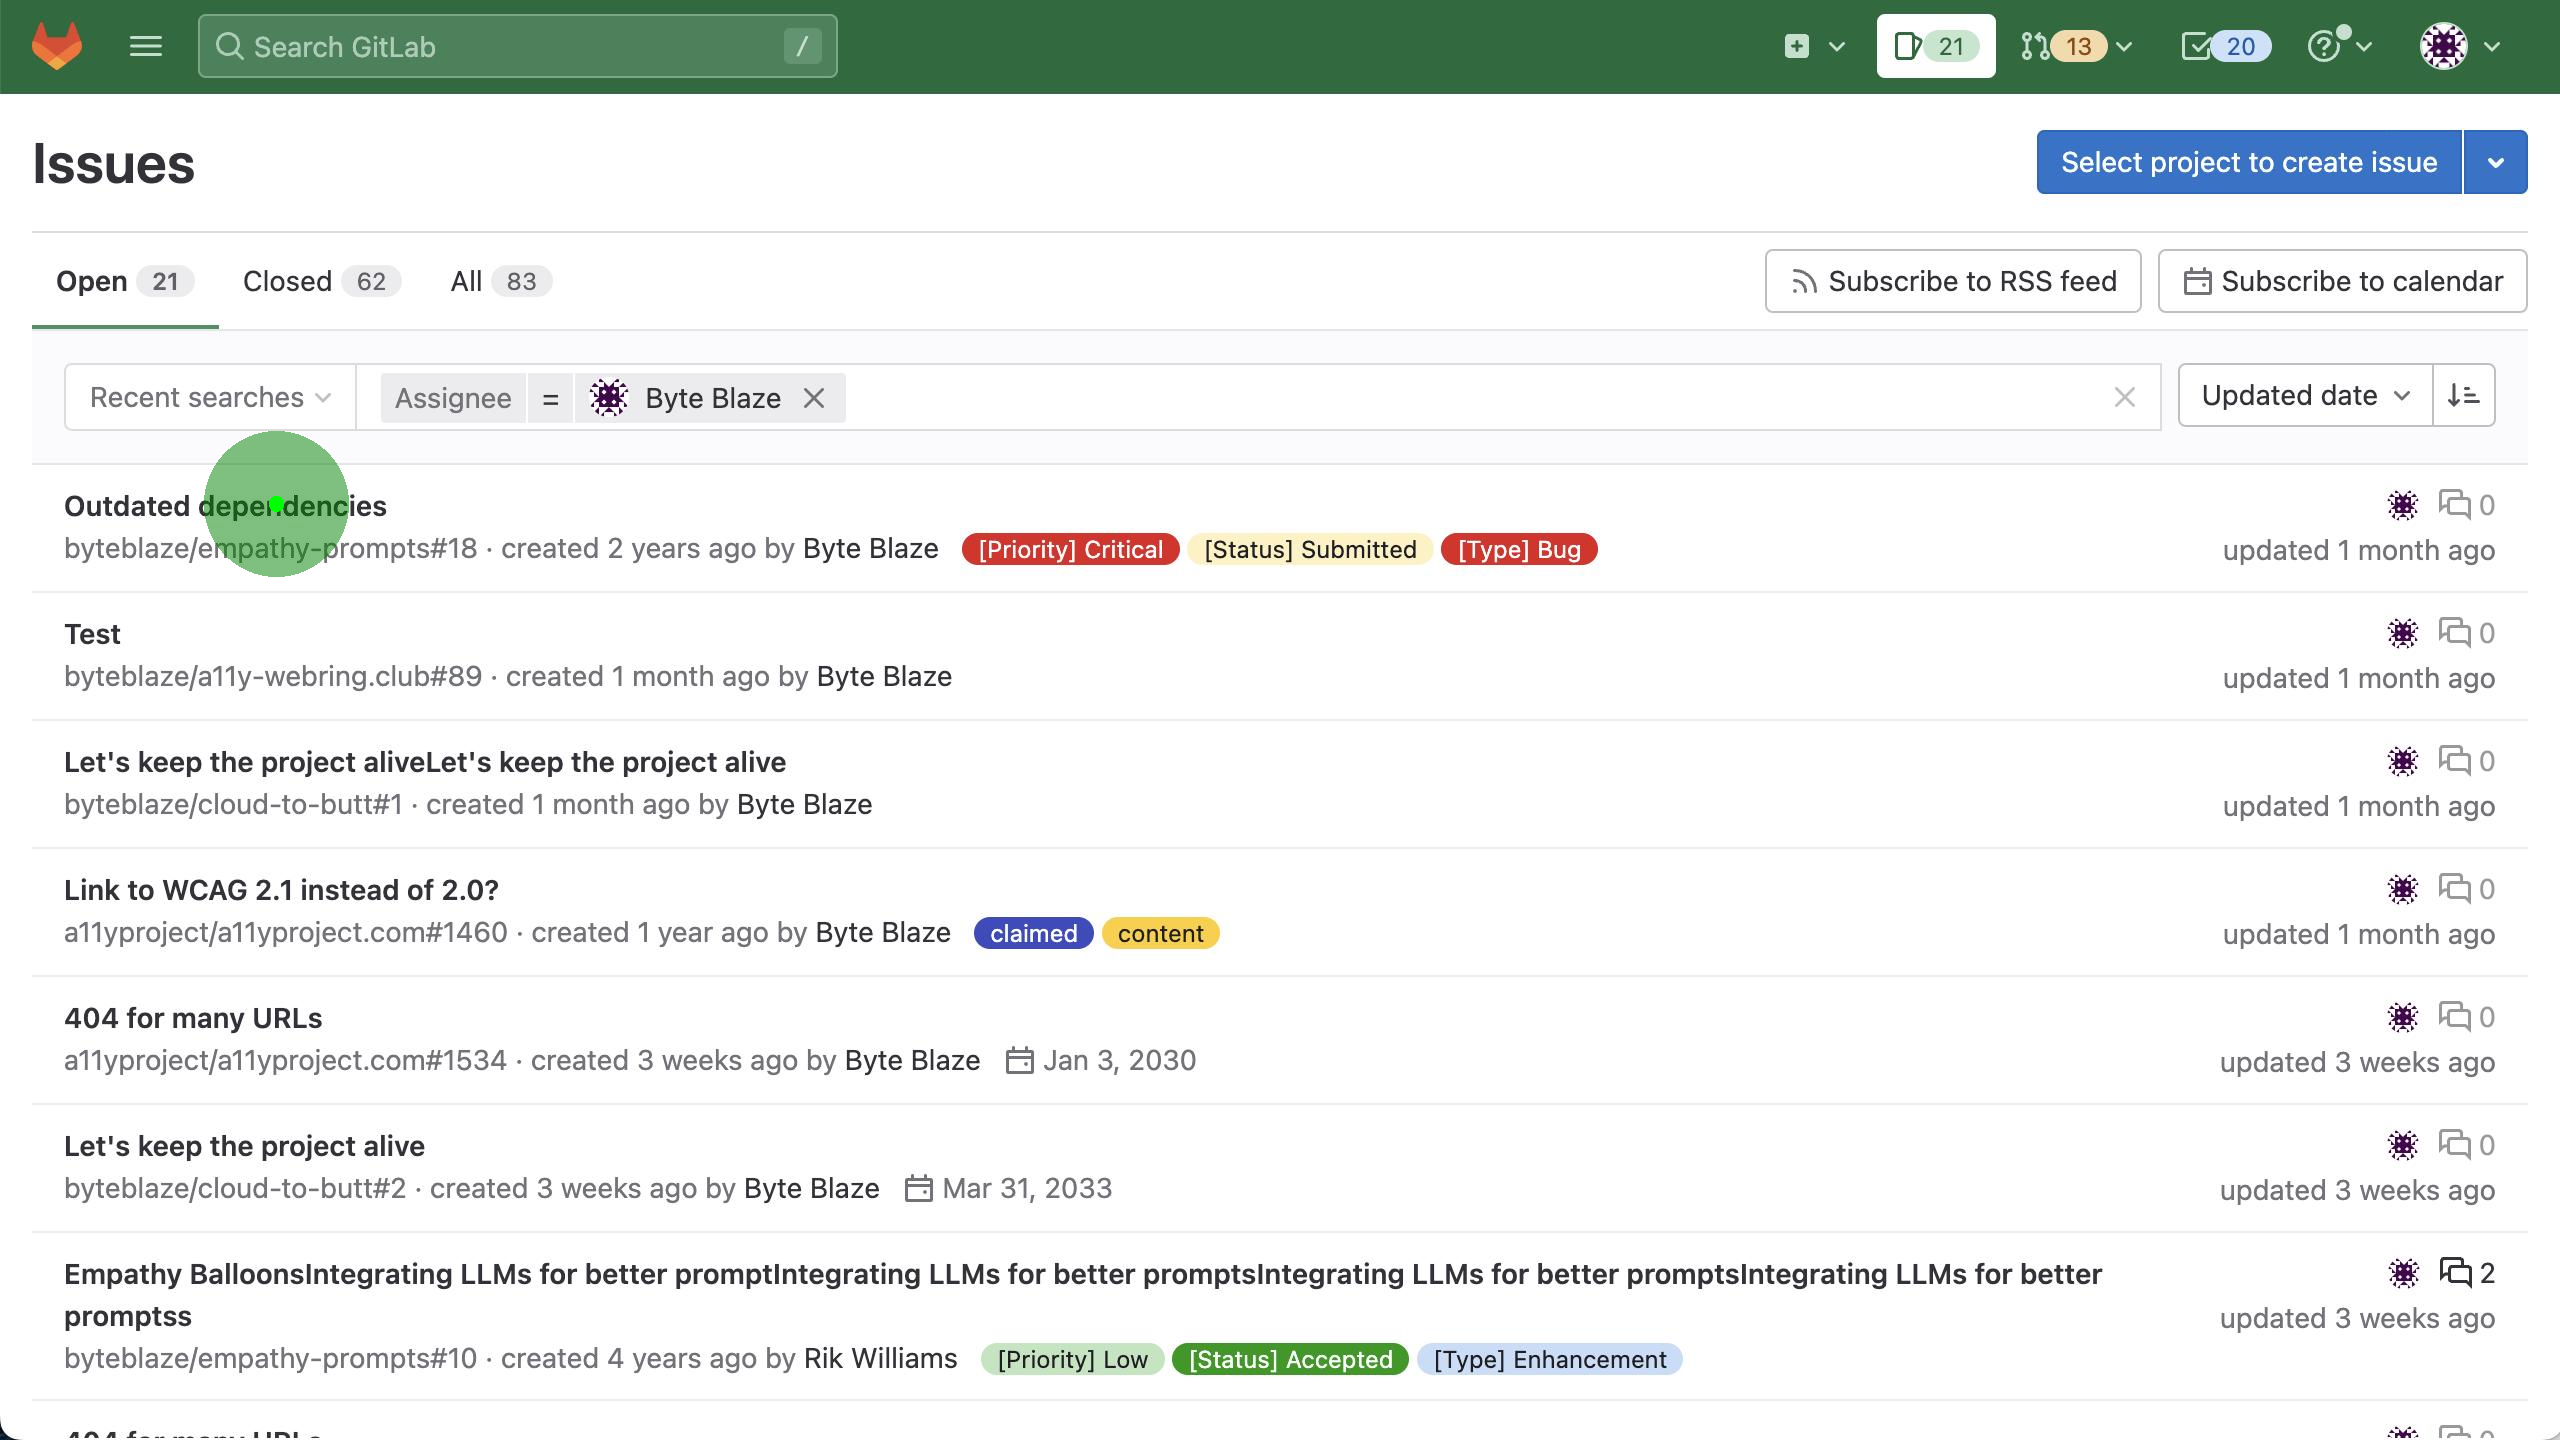

In [42]:
# Example usage
screenshot = "assets/computer_use/computer_use2.jpeg"
user_query = "open the first issue"
output_text, display_image = perform_gui_grounding(
    screenshot, user_query, model, processor
)

# Display results
print(output_text)
display(display_image)